# Matrix Factorization with SPARK ML

### Initialize a spark context and read data into a spark dataframe

In [0]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://apache-mirror.8birdsvideo.com/spark/spark-3.0.0-preview/spark-3.0.0-preview-bin-hadoop2.7.tgz
!tar xf spark-3.0.0-preview-bin-hadoop2.7.tgz
!pip install -q findspark

In [0]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.0-preview-bin-hadoop2.7"

In [0]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

In [0]:
#import libraries
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.sql import Row
import pandas as pd
import numpy as np

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
drive_root = "/content/drive/My Drive/Final Project/"

In [0]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [0]:
#Read train and test set
train = pd.read_csv(drive_root+"Clean Data/train_set_new.csv")
train = train[['user_id','business_id','rating']].copy()
train = train.astype({'user_id':str,'business_id':str,'rating':float})

testcsv = pd.read_csv(drive_root+"Clean Data/last_review.csv")

In [0]:
print(len(train.business_id.unique().tolist()))
print(len(testcsv.business_id.unique().tolist()))
print(len(testcsv.user_id.tolist()))

183398
82498
286130


In [0]:
#save id_review aside for testing
test_reviewid = testcsv.review_id
test = testcsv[['user_id','business_id','rating']].copy()
test = test.astype({'user_id':str,'business_id':str,'rating':float})

In [0]:
#create a dictionary to map Id to an int
aux1=1
aux2 = 300000
users = {}
bus = {}

for i in train.user_id.unique().tolist():
    users[i] = aux1
    aux1+=1
    
bus_unique = set(train.business_id.unique().tolist()+test.business_id.unique().tolist())    
for i in bus_unique:
    bus[i] = aux2
    aux2+=1

In [0]:
train['newuser_id'] = train.user_id.map(users)
train['newbus_id'] = train.business_id.map(bus)

test['newuser_id'] = test.user_id.map(users)
test['newbus_id'] = test.business_id.map(bus)

In [0]:
test.head()

,user_id,business_id,rating,newuser_id,newbus_id
0,---1lKK3aKOuomHnwAkAow,Hqs4YNST_ZHbshwyi4bnsQ,5.00,10718,464362
1,--0kuuLmuYBe3Rmu0Iycww,PYe_FDw6QTbTf66WcGE_tw,2.00,274006,457736
2,--2HUmLkcNHZp0xw6AMBPg,KW9RNyBPmc77f9FsO92qYw,5.00,3497,300815
3,--2vR0DIsmQ6WfcSzKWigw,BLIJ-p5wYuAhw6Pp6mh6mw,3.00,155483,353085
4,--3WaS23LcIXtxyFULJHTA,UKrfUw8quQiQM2N9i1nH0g,4.00,7615,312087


In [0]:
# read the sample of ratings defined on step 1
#lines = spark.read.text('./test_set_new.csv').rdd
#parts = lines.map(lambda row: row.value.split(","))
#ratingsRDD = parts.map(lambda p: Row(userId=str(p[1]), busId=str(p[2]),
#                                     rating=float(p[3])))
ratings = spark.createDataFrame(train[['newuser_id','newbus_id','rating']].copy())

#check rdd DataFrame
print("Size of sampling dataset: {}".format(ratings.count()))

ratings.take(5)

Size of sampling dataset: 4252142


[Row(newuser_id=1, newbus_id=445042, rating=1.0),
 Row(newuser_id=2, newbus_id=336030, rating=5.0),
 Row(newuser_id=3, newbus_id=383772, rating=3.0),
 Row(newuser_id=4, newbus_id=457046, rating=1.0),
 Row(newuser_id=5, newbus_id=411676, rating=2.0)]

In [0]:
#(training, test) = ratings.randomSplit([0.8, 0.2])

#training.take(5)
ratings_test = spark.createDataFrame(test[['newuser_id','newbus_id','rating']].copy())
ratings_test.take(5)

[Row(newuser_id=10718, newbus_id=464362, rating=5.0),
 Row(newuser_id=274006, newbus_id=457736, rating=2.0),
 Row(newuser_id=3497, newbus_id=300815, rating=5.0),
 Row(newuser_id=155483, newbus_id=353085, rating=3.0),
 Row(newuser_id=7615, newbus_id=312087, rating=4.0)]

In [0]:
ratings_test.count()

286130

### Use ALS method to train 

In [0]:
# Build the recommendation model using ALS on the training data
#default parameters
als = ALS(maxIter=10, rank=20, regParam=0.5, userCol="newuser_id", itemCol="newbus_id", ratingCol="rating",\
         coldStartStrategy="drop")

In [0]:
model = als.fit(ratings)

### Evaluation: RMSE of the model

In [0]:
# Evaluate the model on testdata
# Evaluate the model by computing the RMSE on the test data
predictions = model.transform(ratings_test)

In [0]:
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating",
                                predictionCol="prediction")

In [0]:
rmse = evaluator.evaluate(predictions)
print('The RMSE of the model is: {}'.format(evaluator.evaluate(predictions)))

The RMSE of the model is: 1.455270499712746


In [0]:
#predictions.take(5)
predictions.toPandas().head()

,newuser_id,newbus_id,rating,prediction
0,125803,300474,1.00,2.23
1,198656,300539,1.00,2.24
2,262443,300574,5.00,3.07
3,201946,300601,5.00,3.46
4,194911,300601,5.00,3.81


In [0]:
predictions.count()

283217

# Cross validation set up

### Create a parameter grid map

In [0]:
from pyspark.ml.tuning import ParamGridBuilder

#Create a paramgridbuilder spark instance
param_grid = ParamGridBuilder()\
            .addGrid(als.rank, [1, 5, 10, 20])\
            .addGrid(als.regParam, [.01,.05, .5, 1, 5])\
            .build()

We'll try a different set of combinations of rank and the regularization parameter for the default number of maximum iterations (10):
rank: [1,5,10,20]
Regularization parameter: [0.01, 0.05, 0.1, 0.5]

### Create a Cross validator spark instance

In [0]:
from pyspark.ml.tuning import CrossValidator

#Create cross validator for als algorithm evaluating with RMSE and the same evaluator
cv = CrossValidator(estimator = als,
                    estimatorParamMaps = param_grid,
                    evaluator = evaluator,
                    numFolds = 5,
                   collectSubModels=True)

### Run cross validation for training data

In [0]:
model_cv = cv.fit(ratings)  

# the fitting takes forever

In [0]:
#Get best model test predictions and RMSE
best_model = model_cv.bestModel
best_predictions = best_model.transform(ratings_test)
best_rmse = evaluator.evaluate(best_predictions)

In [0]:
# Print evaluation metrics and model parameters
print("Best model RMSE is {}".format(best_rmse))
#get parameters
print("Best model latent factors: {}".format(best_model.rank))
print("Best model regularization paramater: {}".format(best_model._java_obj.parent().getRegParam()))

Best model RMSE is 1.4471118133046168
Best model latent factors: 5
Best model regularization paramater: 0.5


As we can see from the results of the Cross validation, the model with the best RMSE is the one with a rank of 20 factors and a regularization parameter of 0.05. This RMSE is also better than the model with default parameters of rank value of 10 and a regularization parameter of 1.

### Get hyper parameters evaluation performance

In [0]:
lparlist = [(i.rank,i._java_obj.parent().getRegParam()) for i in model_cv.subModels[0]]

rmse_list = model_cv.avgMetrics

cross_results = []

for i in range(0,len(rmse_list)):
    cross_results.append((int(lparlist[i][0]) ,float(lparlist[i][1]), float(rmse_list[i])))

cross_df = pd.DataFrame(cross_results, columns=['rank','L2regularization','RMSE'])
cross_df

,rank,L2regularization,RMSE
0,1,0.01,5.04
1,1,0.05,1.99
2,1,0.50,1.56
3,1,1.00,1.76
4,1,5.00,3.98
5,5,0.01,2.07
6,5,0.05,1.57
7,5,0.50,1.33
8,5,1.00,1.57
9,5,5.00,3.98


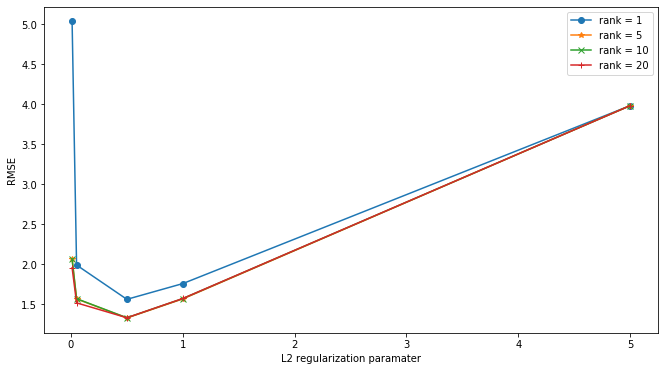

In [0]:
#plot hyper parameters models 
df1 = cross_df[cross_df['rank']==1]
df5 = cross_df[cross_df['rank']==5]
df10 = cross_df[cross_df['rank']==10]
df20 = cross_df[cross_df['rank']==20]

import matplotlib.pyplot as plt
_ = plt.figure(figsize=(11,6))
plt.plot('L2regularization','RMSE' , data=df1, marker='o', label='rank = 1')
plt.plot('L2regularization','RMSE' , data=df5, marker='*', label='rank = 5')
plt.plot('L2regularization','RMSE' , data=df10, marker='x', label='rank = 10')
plt.plot('L2regularization','RMSE' , data=df20, marker='+', label='rank = 20')
plt.ylabel("RMSE")
plt.xlabel('L2 regularization paramater')
plt.legend()


## Get predictions for best model

In [0]:
best_predictions.count()

283217

In [0]:
bp = best_predictions.toPandas()
bp.head()

,newuser_id,newbus_id,rating,prediction
0,125803,300474,1.00,2.18
1,198656,300539,1.00,2.21
2,262443,300574,5.00,3.15
3,201946,300601,5.00,3.41
4,194911,300601,5.00,4.55


In [0]:
ratings_test.toPandas().head()

,newuser_id,newbus_id,rating
0,10718,464362,5.00
1,274006,457736,2.00
2,3497,300815,5.00
3,155483,353085,3.00
4,7615,312087,4.00


In [0]:
bp.newuser_id.value_counts()

2047      1
121454    1
125544    1
123497    1
129642    1
         ..
38328     1
60855     1
58806     1
64949     1
2049      1
Name: newuser_id, Length: 283217, dtype: int64

In [0]:
testcsv.describe()

,rating
count,286130.00
mean,3.77
std,1.52
min,1.00
25%,3.00
50%,5.00
75%,5.00
max,5.00


### Save predictions of best model to file

In [0]:
#map back ids
inverted_users = dict([[v,k] for k,v in users.items()])
inverted_bus = dict([[v,k] for k,v in bus.items()])

bp['user_id'] = bp.newuser_id.map(inverted_users)
bp['business_id'] = bp.newbus_id.map(inverted_bus)

In [0]:
bp.head()

,newuser_id,newbus_id,rating,prediction,user_id,business_id
0,125803,300474,1.00,2.18,tp_N-Oliz3aPYkMzXzKh4A,V8RhIBBwWLW7hYW24Aehig
1,198656,300539,1.00,2.21,pzXQ146CxQCHRxjQcXktIA,F615s6_0g5vAGVFdh7hwGQ
2,262443,300574,5.00,3.15,Wp2LPKHC0agCMe-f3mmzpg,lY5KRmX58HYs2mGaRBDd2A
3,201946,300601,5.00,3.41,NPxRScPZATPjLP8lpSETwQ,6qKjl6xJQzLb9ka-QbTudA
4,194911,300601,5.00,4.55,cd8F1NM8Tn-jTVVa2wZKKA,6qKjl6xJQzLb9ka-QbTudA


In [0]:
bp.sort_values('user_id')

,newuser_id,newbus_id,rating,prediction,user_id,business_id
11193,10718,464362,5.00,3.86,---1lKK3aKOuomHnwAkAow,Hqs4YNST_ZHbshwyi4bnsQ
38844,274006,457736,2.00,3.29,--0kuuLmuYBe3Rmu0Iycww,PYe_FDw6QTbTf66WcGE_tw
257015,3497,300815,5.00,3.20,--2HUmLkcNHZp0xw6AMBPg,KW9RNyBPmc77f9FsO92qYw
274719,155483,353085,3.00,3.34,--2vR0DIsmQ6WfcSzKWigw,BLIJ-p5wYuAhw6Pp6mh6mw
20004,7615,312087,4.00,3.99,--3WaS23LcIXtxyFULJHTA,UKrfUw8quQiQM2N9i1nH0g
...,...,...,...,...,...,...
199399,262244,407049,5.00,1.18,zzrZ8gFESj5pe-SFZ-h0lw,P2uNvUI1RCX8RGKFzj4ceA
35300,266133,368735,1.00,3.26,zzsmdXHUFBYuKUtPbXWjRA,P6zYuNINXKKm5AZ8P5exmQ
94152,149125,300942,5.00,3.42,zzvV3l9IqTRX7Db8nxThbA,LucXqItGj0JZD6EgySOakg
106853,132189,477903,5.00,3.35,zzw0Z6-_VDp9ShIRSKIsQw,1hfYBwAI7pFz50l5n4JpqQ


In [0]:
testcsv.head()

,review_id,user_id,business_id,rating,date
0,wEJK2PeiS6Au0TOyxTyqUA,---1lKK3aKOuomHnwAkAow,Hqs4YNST_ZHbshwyi4bnsQ,5.00,2018-10-11 23:29:57
1,8QLqN2qZPeN6qh4i9tj-rw,--0kuuLmuYBe3Rmu0Iycww,PYe_FDw6QTbTf66WcGE_tw,2.00,2014-04-21 16:58:28
2,dgtVm1qaV3KSzC1Cv7M7kg,--2HUmLkcNHZp0xw6AMBPg,KW9RNyBPmc77f9FsO92qYw,5.00,2018-10-04 02:02:28
3,419OFmkJ4DSc2zkjuxX5hw,--2vR0DIsmQ6WfcSzKWigw,BLIJ-p5wYuAhw6Pp6mh6mw,3.00,2018-01-11 04:24:17
4,6KblMvyPMH__K_eMKhHWOg,--3WaS23LcIXtxyFULJHTA,UKrfUw8quQiQM2N9i1nH0g,4.00,2018-09-03 19:32:11


In [0]:
bp2 = bp[['user_id','business_id','rating','prediction']].copy()
bp2 = bp2.sort_values('user_id')

In [0]:
bp2.user_id.size

283217

In [0]:
#find users the model did not make a prediction on
users_in_test = bp.user_id
missing_pred = testcsv[~testcsv.user_id.isin(bp.user_id)]
missing_pred = missing_pred[['user_id','business_id','rating']].copy()
missing_pred.sort_values('user_id').head(10)

,user_id,business_id,rating
24,--RlSfc-QmcHFGHyX6aVjA,Oz1Ci9y2MnwYyAjVsoZg5Q,4.00
90,-0OE9Pn8vSK-WjJeRtHDtw,DiE8MZaW3c5LFg0e3YQXbg,5.00
446,-5SOwLPH9eLbTdTJrnjxgg,RZR6AYmF0RJAFmgj8I11Gg,1.00
462,-5i7xSNuaXWwODXqjEEEYQ,78op3fqT0itfTYbELGJvxg,4.00
490,-66F_Lt6WZrRua8ZAjXdqg,_5u--hWbsm3h6j3E_6P0mg,5.00
551,-6wGVtKapke4GtIl59j55g,hgFipW1RMfDuQK2MtsWmiw,5.00
827,-AtM3OKL31Sek9zSi3D-MA,6h_v9mTSGYGLAvgOoS-AYQ,5.00
874,-BYjdLFzvOJl1Y5_Z7FrUw,UuO4syJqP1gs-QMkAwEONw,1.00
1002,-DFCC64NXgqrxlO8aLU5rg,-lK3k0x__vrvMCcyhEi2vA,4.00
1316,-HfAVM2M8H4XtKLdQRgHlA,xUJ54bt0kDBUWCtEw9z4fw,1.00


In [0]:
missing_pred['newuser_id'] = missing_pred.user_id.map(users)
missing_pred['newbus_id'] = missing_pred.business_id.map(bus)
missing_pred

,user_id,business_id,rating,newuser_id,newbus_id
24,--RlSfc-QmcHFGHyX6aVjA,Oz1Ci9y2MnwYyAjVsoZg5Q,4.00,98313,333283
90,-0OE9Pn8vSK-WjJeRtHDtw,DiE8MZaW3c5LFg0e3YQXbg,5.00,38849,312345
446,-5SOwLPH9eLbTdTJrnjxgg,RZR6AYmF0RJAFmgj8I11Gg,1.00,266842,455725
462,-5i7xSNuaXWwODXqjEEEYQ,78op3fqT0itfTYbELGJvxg,4.00,153938,372760
490,-66F_Lt6WZrRua8ZAjXdqg,_5u--hWbsm3h6j3E_6P0mg,5.00,256992,362680
...,...,...,...,...,...
285901,zwYCoSqLldPPL6409lySng,IhD8NkSLwF-207jxMOCY3Q,5.00,278268,304117
285947,zxEGx5TJcizUpbufPNusUQ,LfjgSONDpGF7RJOCv-r9Dg,5.00,270794,353685
286061,zz-sXS6jNhVKJQUQtOrmXQ,S51hd1jI1SK7VCtOPkVN2Q,5.00,281669,420573
286075,zzBuXG7J0QMrIZeHq-JfSg,OayEFsHTrtc_px-W9n3rWg,5.00,270270,397274


In [0]:
missing_pred_spark = spark.createDataFrame(missing_pred[['newuser_id','newbus_id','rating']].copy())

In [0]:
missing_pred_try = best_model.transform(missing_pred_spark)

In [0]:
missing_pred_try.toPandas()

,newuser_id,newbus_id,rating,prediction


In [0]:
train[train.business_id=="Oz1Ci9y2MnwYyAjVsoZg5Q"]

,user_id,business_id,rating,newuser_id,newbus_id


There are 2913 observations without a prediction.
The problem is not that the model is not being able to predict a value for these rows, but actually that those observations have business ids not present in the training set, hence the model can't figure out a prediction for those rows (remember that for this dataset we are able to ensure that every user is present both in train and test sets, but we can't do the same for business).

Given this situation we have 2 options:



> Evaluate the model for an incomplete set of predictions (test set - 2,913 observations).

> Give the mean of the vector of predictions to the 2,913 observations in order to have predictions for the entire test set.



#### First Option

In [0]:
predicted_users = [x for x in test.user_id.tolist() if x not in missing_pred.user_id.tolist()]

In [0]:

len(predicted_users)

283217

In [0]:
predicted_users_review = testcsv.review_id[testcsv.user_id.isin(predicted_users)]

In [0]:
predicted_users_review

0         wEJK2PeiS6Au0TOyxTyqUA
1         8QLqN2qZPeN6qh4i9tj-rw
2         dgtVm1qaV3KSzC1Cv7M7kg
3         419OFmkJ4DSc2zkjuxX5hw
4         6KblMvyPMH__K_eMKhHWOg
                   ...          
286125    oOxa0qNQK6RLK-EsasCQzg
286126    ElFGQ4pTi4geHQ2mYBDzug
286127    3NlTwm1txpcG-ZepmZ66Yg
286128    _htR70NBrPuJ5sQzm-RAkw
286129    tTrtMgLmp2REgIG3Pouxdw
Name: review_id, Length: 283217, dtype: object

In [0]:
#add review_id back
bp2['review_id'] = predicted_users_review.tolist()


In [0]:
testcsv.head()

,review_id,user_id,business_id,rating,date
0,wEJK2PeiS6Au0TOyxTyqUA,---1lKK3aKOuomHnwAkAow,Hqs4YNST_ZHbshwyi4bnsQ,5.00,2018-10-11 23:29:57
1,8QLqN2qZPeN6qh4i9tj-rw,--0kuuLmuYBe3Rmu0Iycww,PYe_FDw6QTbTf66WcGE_tw,2.00,2014-04-21 16:58:28
2,dgtVm1qaV3KSzC1Cv7M7kg,--2HUmLkcNHZp0xw6AMBPg,KW9RNyBPmc77f9FsO92qYw,5.00,2018-10-04 02:02:28
3,419OFmkJ4DSc2zkjuxX5hw,--2vR0DIsmQ6WfcSzKWigw,BLIJ-p5wYuAhw6Pp6mh6mw,3.00,2018-01-11 04:24:17
4,6KblMvyPMH__K_eMKhHWOg,--3WaS23LcIXtxyFULJHTA,UKrfUw8quQiQM2N9i1nH0g,4.00,2018-09-03 19:32:11


In [0]:
bp2

,user_id,business_id,rating,prediction,review_id
11193,---1lKK3aKOuomHnwAkAow,Hqs4YNST_ZHbshwyi4bnsQ,5.00,3.86,wEJK2PeiS6Au0TOyxTyqUA
38844,--0kuuLmuYBe3Rmu0Iycww,PYe_FDw6QTbTf66WcGE_tw,2.00,3.29,8QLqN2qZPeN6qh4i9tj-rw
257015,--2HUmLkcNHZp0xw6AMBPg,KW9RNyBPmc77f9FsO92qYw,5.00,3.20,dgtVm1qaV3KSzC1Cv7M7kg
274719,--2vR0DIsmQ6WfcSzKWigw,BLIJ-p5wYuAhw6Pp6mh6mw,3.00,3.34,419OFmkJ4DSc2zkjuxX5hw
20004,--3WaS23LcIXtxyFULJHTA,UKrfUw8quQiQM2N9i1nH0g,4.00,3.99,6KblMvyPMH__K_eMKhHWOg
...,...,...,...,...,...
199399,zzrZ8gFESj5pe-SFZ-h0lw,P2uNvUI1RCX8RGKFzj4ceA,5.00,1.18,oOxa0qNQK6RLK-EsasCQzg
35300,zzsmdXHUFBYuKUtPbXWjRA,P6zYuNINXKKm5AZ8P5exmQ,1.00,3.26,ElFGQ4pTi4geHQ2mYBDzug
94152,zzvV3l9IqTRX7Db8nxThbA,LucXqItGj0JZD6EgySOakg,5.00,3.42,3NlTwm1txpcG-ZepmZ66Yg
106853,zzw0Z6-_VDp9ShIRSKIsQw,1hfYBwAI7pFz50l5n4JpqQ,5.00,3.35,_htR70NBrPuJ5sQzm-RAkw


In [0]:
#save incomplete predictions to csv
bp2.to_csv(drive_root+"MF model/MF_predictions_subset.csv", index=False)

#### Second Option

In [0]:
#replace with mean
pred_mean = bp.prediction.mean()

In [0]:
missing2 = testcsv.iloc[missing_pred.index].copy()

In [0]:
missing2['prediction'] = pred_mean

In [0]:
missing2

,review_id,user_id,business_id,rating,date,prediction
24,-3XiOw_tdVwRsDD-j7Me-g,--RlSfc-QmcHFGHyX6aVjA,Oz1Ci9y2MnwYyAjVsoZg5Q,4.00,2018-11-04 07:01:17,3.25
90,FDKuzjb4K9fRUvqxbhMn3Q,-0OE9Pn8vSK-WjJeRtHDtw,DiE8MZaW3c5LFg0e3YQXbg,5.00,2017-08-24 16:15:14,3.25
446,TBPSJHaQQdRF_dqDGwNu3g,-5SOwLPH9eLbTdTJrnjxgg,RZR6AYmF0RJAFmgj8I11Gg,1.00,2018-05-06 00:31:09,3.25
462,AaVGUlWFfJNNdpxgr23atA,-5i7xSNuaXWwODXqjEEEYQ,78op3fqT0itfTYbELGJvxg,4.00,2017-05-04 19:28:13,3.25
490,_A_3wcLqK-2PscagzN0qEw,-66F_Lt6WZrRua8ZAjXdqg,_5u--hWbsm3h6j3E_6P0mg,5.00,2018-08-02 03:15:02,3.25
...,...,...,...,...,...,...
285901,TY7PKEXxmzzgQzWG8A264A,zwYCoSqLldPPL6409lySng,IhD8NkSLwF-207jxMOCY3Q,5.00,2018-04-17 19:23:12,3.25
285947,BAYZz4CV5_igsaXk81vdmQ,zxEGx5TJcizUpbufPNusUQ,LfjgSONDpGF7RJOCv-r9Dg,5.00,2018-01-13 19:56:02,3.25
286061,9uklFZiXKBbUz7cx2vQTYQ,zz-sXS6jNhVKJQUQtOrmXQ,S51hd1jI1SK7VCtOPkVN2Q,5.00,2016-01-12 21:01:18,3.25
286075,iff1Hv5Id5Klaw3-LxbNiw,zzBuXG7J0QMrIZeHq-JfSg,OayEFsHTrtc_px-W9n3rWg,5.00,2015-03-14 16:44:28,3.25


In [0]:
pred_complete = bp2.append(missing2[['user_id','business_id','rating','prediction','review_id']].copy())

In [0]:
pred_complete.to_csv(drive_root+"MF model/MF_predictions_meanreplaced.csv", index=False)